# Group 1 - NLP Fake News Classification Challenge

**Ironhack NLP Challenge** 

Group 1 by: Ben, Bianca, Quincy and Armando.

Model: CountVectorizer + MultinomialNB

by: Ben
___

Quick Overview:

- Model: Bag-of-Words (CountVectorizer) + Multinomial Naive Bayes (non-ensemble baseline).Pre-Processing**.
- Goal: Provide a classic NLP baseline and compare its behaviour vs our stronger linear model (TF-IDF + LinearSVC).
- Key idea: NB learns class probabilities from word counts


___
Files:

Model File: model_LinearCSV_LR.joblib

Notebook file: model_Linearsvc_lr_no_prepro.ipynb

CSV_Produced by model: Predict_LinearSCV_LR.csv
___
**Expected repo structure**
```
repo/
  data/
    training_data_lowercase.csv
    testing_data_lowercase_nolabels.csv
  code/
    model1.ipynb   (was main)
    model2.ipynb  (etc)
outputs/
  Predict_LinearSCV_RF.csv etc.
  models/
   Model1_LinearCSV.joblib etc.
```


## Imports



In [1]:
import re
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## File paths


In [2]:
# Robust: locate the repo root by walking upward until we find a /data folder
HERE = Path(__file__).parent if "__file__" in globals() else Path.cwd()

PROJECT_ROOT = None
for p in [HERE] + list(HERE.parents):
    if (p / "data").exists():
        PROJECT_ROOT = p
        break

assert PROJECT_ROOT is not None, "Could not find repo root (a folder containing /data)."

DATA_DIR = PROJECT_ROOT / "data"

TRAIN_FILE = DATA_DIR / "training_data_lowercase.csv"
TEST_FILE  = DATA_DIR / "testing_data_lowercase_nolabels.csv"

assert TRAIN_FILE.exists(), f"Missing: {TRAIN_FILE.resolve()}"
assert TEST_FILE.exists(),  f"Missing: {TEST_FILE.resolve()}"

print("✓ Files found:", TRAIN_FILE.name, "and", TEST_FILE.name)
print("PROJECT_ROOT:", PROJECT_ROOT)


✓ Files found: training_data_lowercase.csv and testing_data_lowercase_nolabels.csv
PROJECT_ROOT: C:\Users\Ben_h\Ironhack\Ironhack-week4\project-nlp-challenge-group1


> **Comments:**  
> - We load data from the repo root.


## Load data



In [3]:
train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

print("\nTrain columns:", list(train_df.columns))
print("Test columns :", list(test_df.columns))

# train_df.head()
test_df.head()


Train shape: (34151, 1)
Test shape : (9983, 1)

Train columns: ['0\tdonald trump sends out embarrassing new year‚s eve message; this is disturbing']
Test columns : ['2\tcopycat muslim terrorist arrested with assault weapons']


,2\tcopycat muslim terrorist arrested with assault weapons
0,2\twow! chicago protester caught on camera adm...
1,2\tgermany's fdp look to fill schaeuble's big ...
2,2\tmi school sends welcome back packet warning...
3,2\tu.n. seeks 'massive' aid boost amid rohingy...
4,2\tdid oprah just leave ‚nasty‚ hillary wishin...


In [4]:
# ---- missing-value checks (top 10 columns by NA rate) ---
na_train = train_df.isna().mean().sort_values(ascending=False).head(10)
na_test = test_df.isna().mean().sort_values(ascending=False).head(10)

# print("Top NA rates (train):")
# print(na_train.__str__())

# print("\nTop NA rates (test):")
# print(na_test.__str__())

print("type(na_train):", type(na_train))
print("type(na_test) :", type(na_test))
print("na_train preview:", na_train)

type(na_train): <class 'pandas.Series'>
type(na_test) : <class 'pandas.Series'>
na_train preview: 0\tdonald trump sends out embarrassing new year‚s eve message; this is disturbing    0.0
dtype: float64


### Column names



In [5]:
import pandas as pd
from pathlib import Path

# Setup paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
TRAIN_FILE = DATA_DIR / "training_data_lowercase.csv"
TEST_FILE = DATA_DIR / "testing_data_lowercase_nolabels.csv"

# Load data with correct delimiter (tab-separated)
train_df = pd.read_csv(TRAIN_FILE, sep='\t', header=None, names=['target', 'text'])
test_df = pd.read_csv(TEST_FILE, sep='\t', header=None, names=['target', 'text'])

# Now define your column references
TEXT_COL  = "text"
TARGET_COL = "target"

# Assertions
assert TEXT_COL in train_df.columns, f"TEXT_COL='{TEXT_COL}' not found."
assert TEXT_COL in test_df.columns, f"TEXT_COL='{TEXT_COL}' not found in test."
assert TARGET_COL in train_df.columns, f"TARGET_COL='{TARGET_COL}' not found."
assert TARGET_COL in test_df.columns, f"TARGET_COL='{TARGET_COL}' not found in test."

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")

# Label distribution
display(train_df[TARGET_COL].value_counts(dropna=False))


Train shape: (34152, 2)
Test shape: (9984, 2)

Train columns: ['target', 'text']
Test columns: ['target', 'text']


target
0    17572
1    16580
Name: count, dtype: int64

> **Comments:**  
> - Loaded CSV files and set column names Text & Target
> - Used the regex '\t' to separate the columns.
> - The column names are 'target' and 'text'.


## Preprocessing



In [6]:

# Clean the artifacts and symbols from the dataset.

def clean_text(text: str) -> str:
    text = str(text)

    # Keep letters + whitespace (remove punctuation, digits, symbols)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Remove standalone single letters
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Lowercase
    return text.lower()


Comments: standard regex to remove symbols,


In [7]:
# Apply NA handling + cleaning to the text columns
train_df[TEXT_COL] = train_df[TEXT_COL].fillna("").map(clean_text)
test_df[TEXT_COL]  = test_df[TEXT_COL].fillna("").map(clean_text)

# NO PREPROCESSING
# train_df[TEXT_COL] = train_df[TEXT_COL].fillna("")
# test_df[TEXT_COL]  = test_df[TEXT_COL].fillna("")

# Keep label cleanup
train_df[TARGET_COL] = train_df[TARGET_COL].astype(str).str.strip()

train_df[[TEXT_COL, TARGET_COL]].head()

# Target (optional label cleanup)
train_df[TARGET_COL] = train_df[TARGET_COL].astype(str).str.strip()

train_df[[TEXT_COL, TARGET_COL]].head() # Check data


,text,target
0,donald trump sends out embarrassing new year e...,0
1,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes an internet joke ...,0
3,trump is so obsessed he even has obama name co...,0
4,pope francis just called out donald trump duri...,0


##  Train/Validation split
We split once for fast iteration and fair model comparison.


In [8]:

X = train_df[TEXT_COL]
y = train_df[TARGET_COL]
X_test = test_df[TEXT_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (27321,) Val: (6831,)


##  Stemming


In [9]:
# Normalize the data and tokenize
import nltk
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english") # add stopwords with stemming



def stem_tokenizer(text: str):
    # keep letters only, lowercase
    tokens = re.findall(r"[a-zA-Z]+", text.lower())
    return [stemmer.stem(t) for t in tokens]


Notes:

**Stemming**: This is reducing sparsity by merging word variants, but may harm phrase-based words, So this may not really improve results, So I am just going to do this as an experiment.

**Stopwords** Just to see how this effects the results baised on the word signals.

##  Model
CountVectorizer + MultinombialNB


In [26]:
# CountVectorizer + MultinomialNB + StopWords

Model2 = Pipeline(steps=[
    ("bow", CountVectorizer(tokenizer=stem_tokenizer, stop_words="english",ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", MultinomialNB(alpha=0.5)) # Reduce Alpha for less smoothing, seems to improve accuracy slightly.
])

t0 = time.perf_counter()
Model2.fit(X_train, y_train)
fit_s = time.perf_counter() - t0

y_pred = Model2.predict(X_val)

print("Model 2 Count Vectorizer + MultinominalNB")
print("Fit seconds:", round(fit_s, 3))
print("Accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("F1 (weighted):", round(f1_score(y_val, y_pred, average="weighted"), 4))

vect = Model2.named_steps["bow"]
print("Vocab size:", len(vect.vocabulary_))
print("the" in vect.vocabulary_) # check stopwords

C:\Users\Ben_h\Ironhack\Ironhack-week4\project-nlp-challenge-group1\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Ben_h\Ironhack\Ironhack-week4\project-nlp-challenge-group1\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher

Model 2 Count Vectorizer + MultinominalNB
Fit seconds: 1.31
Accuracy: 0.9365
F1 (weighted): 0.9365
Vocab size: 34785
False


**Comments:**

Here I kept the ngrams the same as this appears to be the best for this dataset. The same goes for min and max df. However I found adjusting the alpha with the countvectorizer to improve the accuracy slightly.




              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3515
           1       0.94      0.93      0.93      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



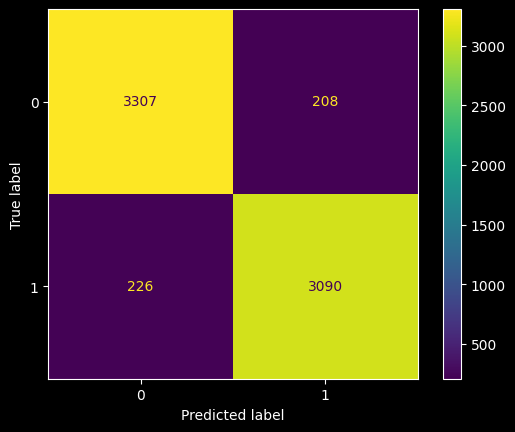

In [27]:
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.show()


##   CountVectorizer + MultinomialNB: Final Evaluation

 **Comments:**

Even though we are using a multinomial model, the performance differs are still very small here, but the results are still very good.


The F1 score here is 0.93, slightly lower than LinearSVC.

What I think is happening? NB treats all the tokens independendtly and works directly on counts; LinearSVC + TF-IDF typically finds unique patterns in the text better.

Comparison: Slightly behind TF-IDF + LinearSVC (0.95), reinforcing that TF-IDF reweighting and linear margins are strong for this dataset.

I think this is best to Keep this model as a classic baseline and move on to a different family of models.


## Export model results CSV



In [28]:
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)

best_pipe = ensemble_pipe
test_pred = best_pipe.predict(X_test)  
pred_path = OUT_DIR / "Predict_countvectorizer_multinom.csv"

# If your test file has an ID column, set it here. Otherwise we use row index.
ID_COL = "id" if "id" in test_df.columns else None

if ID_COL is not None:
    out_df = pd.DataFrame({ID_COL: test_df[ID_COL], TARGET_COL: test_pred})
else:
    out_df = pd.DataFrame({"id": np.arange(len(test_df)), TARGET_COL: test_pred})

out_df.to_csv(pred_path, index=False)
print("✓ Saved:", pred_path.resolve())
out_df.head()


NameError: name 'ensemble_pipe' is not defined

## 13) Save Model

In [18]:
from pathlib import Path
import joblib

# Use the model you trained earlier
best_pipe = Model1  # Reference the pipeline from Cell #20

# Use PROJECT_ROOT (already defined in your notebook)
MODELS_DIR = PROJECT_ROOT / "Models"
MODELS_DIR.mkdir(exist_ok=True)

# Define model path clearly
model_name = "model_countvectorizer_multinom.joblib"
model_path = MODELS_DIR / model_name

# Save the model
joblib.dump(best_pipe, model_path)

print("✓ Model saved to:", model_path.resolve())


✓ Model saved to: C:\Users\Ben_h\Ironhack\Ironhack-week4\project-nlp-challenge-group1\models\model_LinearCSV_LR.joblib
